In [41]:
def lvcounts_query(run_to_analyze,cummulative_to_use):
    
    query = """
    with uid_groups as (
    -- counts of UIDS per NID, partion() needed to keep UID
        select run_id, network_id, uid, count(uid) over (partition by run_id,network_id) as cardinality
        from aim4.network_id )
    -- Filter out UIDs that do not participate in at least one record linakage (Count(uid>1) per NID)
    , linked_uids as (
        select run_id, network_id, uid, cardinality
        from uid_groups
        where cardinality > 1
    )
    -- All UIDs seen from runs <= :run_to_analyze
    , linked_uids_run as (
        select {run_to_analyze} as run_to_analyze, run_id, network_id, uid, cardinality 
        from linked_uids
        where run_id <= {run_to_analyze}
    )
    -- Last run for every UID to local last NID
    , lastrun as (
       select uid, max(run_id) as last_run
       from linked_uids_run
       group by uid 
    )
    -- Use the network_id from the last run (based on conversation with Toan about using last NID NID)
    , linked_uids_lastrun as (
       select lur.run_to_analyze as run_to_analyze, last_run, lur.uid, lur.network_id as last_network_id, cardinality 
       from linked_uids_run lur join lastrun lr on (lur.uid = lr.uid and lur.run_id = lr.last_run)
    -- Add linkage and clinical vars to UIDs in this run using run cummulative data set
    )
    , linked_clinical_lastrun as (
        select distinct run_to_analyze, last_network_id, ms.uid as uid, ms.id, mrn, d_source, first_name, last_name,sex, dob,ssn,address, city, state,zip, phone,ssn4
        , startdate, enddate, heightinches, weightpounds, siteid
        from linked_uids_lastrun lur join aim4.merged_source ms on (lur.uid = ms.uid)
        join {cummulative_to_use} c on (ms.id = c.study_id)
    )
    , linkage_vars_by_nid as (
        select last_network_id
            , case when count(first_name)=0 then 0 else 1 end as fn_linkage_val
            , case when count(last_name)=0 then 0 else 1 end as ln_linkage_val
            , case when count(sex)=0 then 0 else 1 end as sex_linkage_val
            , case when count(dob)=0 then 0 else 1 end as dob_linkage_val
            , case when count(ssn) =0 then 0 else 1 end as ssn_linkage_val
            , case when count(address)=0 then 0 else 1 end as address_linkage_val
            , case when count(city)=0 then 0 else 1 end as city_linkage_val
            , case when count(state)=0 then 0 else 1 end as state_linkage_val
            , case when count(zip)= 0 then 0 else 1 end as zip_linkage_val
            , case when count(phone)=0 then 0 else 1 end as phone_linkage_val
            , case when count(ssn4)=0 then 0 else 1 end as ssn4_linkage_val
        from linked_clinical_lastrun
        group by last_network_id
    )
    select 'unlinked' as type
           , count(uid) as denominator
           , count(first_name) as n_fn
           , count(last_name) as n_ln
           , count(sex) as n_sex
           , count(dob) as n_dob
           , count(ssn) as n_ssn
           , count(address) as n_address
           , count(city) as n_city
           , count(state) as n_state
           , count(zip) as n_zip
           , count(phone) as n_phone
           , count(ssn4) as n_ssn4
    from linked_clinical_lastrun
    union all
    (select 'linked'
           , count(last_network_id)
           , sum(fn_linkage_val)
           , sum(ln_linkage_val)
           , sum(sex_linkage_val)
           , sum(dob_linkage_val)
           , sum(ssn_linkage_val)
           , sum(address_linkage_val)
           , sum(city_linkage_val)
           , sum(state_linkage_val)
           , sum(zip_linkage_val)
           , sum(phone_linkage_val)
           , sum(ssn4_linkage_val)
    from linkage_vars_by_nid);""".format(run_to_analyze=run_to_analyze, cummulative_to_use = cummulative_to_use)
    
    return query
# run_cohort_lvcounts = pd.read_sql(lvcounts_query,engine)
# run_cohort_lvcounts

In [66]:
def lvpercents_query(run_to_analyze,cummulative_to_use):
    
    query = """
    with uid_groups as (
    -- counts of UIDS per NID, partion() needed to keep UID
        select run_id, network_id, uid, count(uid) over (partition by run_id,network_id) as cardinality
        from aim4.network_id )
    -- Filter out UIDs that do not participate in at least one record linakage (Count(uid>1) per NID)
    , linked_uids as (
        select run_id, network_id, uid, cardinality
        from uid_groups
        where cardinality > 1
    )
    -- All UIDs seen from runs <= :run_to_analyze
    , linked_uids_run as (
        select {run_to_analyze} as run_to_analyze, run_id, network_id, uid, cardinality 
        from linked_uids
        where run_id <= {run_to_analyze}
    )
    -- Last run for every UID to local last NID
    , lastrun as (
       select uid, max(run_id) as last_run
       from linked_uids_run
       group by uid 
    )
    -- Use the network_id from the last run (based on conversation with Toan about using last NID NID)
    , linked_uids_lastrun as (
       select lur.run_to_analyze as run_to_analyze, last_run, lur.uid, lur.network_id as last_network_id, cardinality 
       from linked_uids_run lur join lastrun lr on (lur.uid = lr.uid and lur.run_id = lr.last_run)
    -- Add linkage and clinical vars to UIDs in this run using run cummulative data set
    )
    , linked_clinical_lastrun as (
        select distinct run_to_analyze, last_network_id, ms.uid as uid, ms.id, mrn, d_source, first_name, last_name,sex, dob,ssn,address, city, state,zip, phone,ssn4
        , startdate, enddate, heightinches, weightpounds, siteid
        from linked_uids_lastrun lur join aim4.merged_source ms on (lur.uid = ms.uid)
        join {cummulative_to_use} c on (ms.id = c.study_id)
    )
    , linkage_vars_by_nid as (
        select last_network_id
            , case when count(first_name)=0 then 0 else 1 end as fn_linkage_val
            , case when count(last_name)=0 then 0 else 1 end as ln_linkage_val
            , case when count(sex)=0 then 0 else 1 end as sex_linkage_val
            , case when count(dob)=0 then 0 else 1 end as dob_linkage_val
            , case when count(ssn) =0 then 0 else 1 end as ssn_linkage_val
            , case when count(address)=0 then 0 else 1 end as address_linkage_val
            , case when count(city)=0 then 0 else 1 end as city_linkage_val
            , case when count(state)=0 then 0 else 1 end as state_linkage_val
            , case when count(zip)= 0 then 0 else 1 end as zip_linkage_val
            , case when count(phone)=0 then 0 else 1 end as phone_linkage_val
            , case when count(ssn4)=0 then 0 else 1 end as ssn4_linkage_val
        from linked_clinical_lastrun
        group by last_network_id
    )
    , lv_counts as  (
    select 'unlinked' as type
           , count(uid) as denominator
           , count(first_name) as n_fn
           , count(last_name) as n_ln
           , count(sex) as n_sex
           , count(dob) as n_dob
           , count(ssn) as n_ssn
           , count(address) as n_address
           , count(city) as n_city
           , count(state) as n_state
           , count(zip) as n_zip
           , count(phone) as n_phone
           , count(ssn4) as n_ssn4
    from linked_clinical_lastrun
    union all
    select 'linked'
           , count(last_network_id)
           , sum(fn_linkage_val)
           , sum(ln_linkage_val)
           , sum(sex_linkage_val)
           , sum(dob_linkage_val)
           , sum(ssn_linkage_val)
           , sum(address_linkage_val)
           , sum(city_linkage_val)
           , sum(state_linkage_val)
           , sum(zip_linkage_val)
           , sum(phone_linkage_val)
           , sum(ssn4_linkage_val)
    from linkage_vars_by_nid
    )
    , lv_percents as (
        select type
           , cast(n_fn*100.0/denominator as numeric(7,1)) as fn_complete
           , cast(n_ln*100.0/denominator as numeric(7,1)) as ln_complete
           , cast(n_sex*100.0/denominator as numeric(7,1)) as sex_complete
           , cast(n_dob*100.0/denominator as numeric(7,1)) as dob_complete
           , cast(n_ssn*100.0/denominator as numeric(7,1)) as ssn_complete
           , cast(n_address*100.0/denominator as numeric(7,1)) as address_complete
           , cast(n_city*100.0/denominator as numeric(7,1)) as city_complete
           , cast(n_state*100.0/denominator as numeric(7,1)) as state_complete
           , cast(n_zip*100.0/denominator as numeric(7,1)) as zip_complete
           , cast(n_phone*100.0/denominator as numeric(7,1)) as phone_complete
           , cast(n_ssn4*100.0/denominator as numeric(7,1)) as ssn4_complete
        from lv_counts
    )
    select * from lv_percents;""".format(run_to_analyze=run_to_analyze,cummulative_to_use=cummulative_to_use)
    return query
    # run1_cohort_lvpercents = pd.read_sql(query,engine)
    # run1_cohort_lvpercents

In [74]:
def obsperiod_query(run_to_analyze,cummulative_to_use):
    query="""
    with uid_groups as (
    -- counts of UIDS per NID, partion() needed to keep UID
        select run_id, network_id, uid, count(uid) over (partition by run_id,network_id) as cardinality
        from aim4.network_id )
    -- Filter out UIDs that do not participate in at least one record linakage (Count(uid>1) per NID)
    , linked_uids as (
        select run_id, network_id, uid, cardinality
        from uid_groups
        where cardinality > 1
    )
    -- All UIDs seen from runs <= :run_to_analyze
    , linked_uids_run as (
        select {run_to_analyze} as run_to_analyze, run_id, network_id, uid, cardinality 
        from linked_uids
        where run_id <= {run_to_analyze}
    )
    -- Last run for every UID to local last NID
    , lastrun as (
       select uid, max(run_id) as last_run
       from linked_uids_run
       group by uid 
    )
    -- Use the network_id from the last run (based on conversation with Toan about using last NID NID)
    , linked_uids_lastrun as (
       select lur.run_to_analyze as run_to_analyze, last_run, lur.uid, lur.network_id as last_network_id, cardinality 
       from linked_uids_run lur join lastrun lr on (lur.uid = lr.uid and lur.run_id = lr.last_run)
    )
    -- Add linkage and clinical vars to UIDs in this run using run cummulative data set
    , linked_clinical_lastrun as (
        select distinct run_to_analyze, last_network_id, ms.uid as uid, ms.id, mrn, d_source, first_name, last_name,sex, dob,ssn,address, city, state,zip, phone,ssn4
        , startdate, enddate, heightinches, weightpounds, siteid
        from linked_uids_lastrun lur join aim4.merged_source ms on (lur.uid = ms.uid)
        join {cummulative_to_use} c on (ms.id = c.study_id)
    )
    -- obs period = min/max date in months using stackoverflow formula for #months.
    -- ATTN: max_enddate set to max(startdate)
    , obs_period_uid as (
        select 'Unlinked' as type, uid as "UID/NID", min(startdate) as min_startdate, max(startdate) as max_enddate
        , EXTRACT(year FROM age(max(startdate),min(startdate)))*12 + EXTRACT(month FROM age(max(startdate),min(startdate))) + 1 as obs_months
        from linked_clinical_lastrun
        group by uid)
    , obs_period_nid as (
        select 'Linked' as type, last_network_id, min(startdate) as min_startdate, max(startdate) as max_enddate
        , EXTRACT(year FROM age(max(startdate),min(startdate)))*12 + EXTRACT(month FROM age(max(startdate),min(startdate))) + 1 as obs_months
        from linked_clinical_lastrun
        group by last_network_id
    )
    , obs_period_stats as (
    select 'unlinked' as type
        , min(min_startdate) as min_startdate
        , max(max_enddate) as max_enddate
        , min(obs_months) as min_obs_months
        , max(obs_months) as max_obs_months
        , avg(obs_months)::numeric(7,1) as avg_obs_months
              from obs_period_uid
    UNION ALL
    select 'linked'
        , min(min_startdate)
          , max(max_enddate)
          , min(obs_months)
          , max(obs_months)
          , avg(obs_months)::numeric(7,1)
          from obs_period_nid
    )
    select type, min_startdate, max_enddate, min_obs_months, max_obs_months, avg_obs_months from obs_period_stats;""".format(run_to_analyze = run_to_analyze, cummulative_to_use = cummulative_to_use)

    return query

def obsperiod_histogram_query(run_to_analyze,cummulative_to_use):
    query = """
    with uid_groups as (
    -- counts of UIDS per NID, partion() needed to keep UID
        select run_id, network_id, uid, count(uid) over (partition by run_id,network_id) as cardinality
        from aim4.network_id )
    -- Filter out UIDs that do not participate in at least one record linakage (Count(uid>1) per NID)
    , linked_uids as (
        select run_id, network_id, uid, cardinality
        from uid_groups
        where cardinality > 1
    )
    -- All UIDs seen from runs <= run_to_analyze
    , linked_uids_run as (
        select {run_to_analyze} as run_to_analyze, run_id, network_id, uid, cardinality 
        from linked_uids
        where run_id <= {run_to_analyze}
    )
    -- Last run for every UID to local last NID
    , lastrun as (
       select uid, max(run_id) as last_run
       from linked_uids_run
       group by uid 
    )
    -- Use the network_id from the last run (based on conversation with Toan about using last NID NID)
    , linked_uids_lastrun as (
       select lur.run_to_analyze as run_to_analyze, last_run, lur.uid, lur.network_id as last_network_id, cardinality 
       from linked_uids_run lur join lastrun lr on (lur.uid = lr.uid and lur.run_id = lr.last_run)
    )
    -- Add linkage and clinical vars to UIDs in this run using run cummulative data set
    , linked_clinical_lastrun as (
        select distinct run_to_analyze, last_network_id, ms.uid as uid, ms.id, mrn, d_source, first_name, last_name,sex, dob,ssn,address, city, state,zip, phone,ssn4
        , startdate, enddate, heightinches, weightpounds, siteid
        from linked_uids_lastrun lur join aim4.merged_source ms on (lur.uid = ms.uid)
        join {cummulative_to_use} c on (ms.id = c.study_id)
    )
    -- obs period = min/max date in months using stackoverflow formula for #months.
    -- ATTN: max_enddate set to max(startdate)
    , obs_period_uid as (
        select 'Unlinked' as type, uid as uid, min(startdate) as min_startdate, max(startdate) as max_enddate
        , EXTRACT(year FROM age(max(startdate),min(startdate)))*12 + EXTRACT(month FROM age(max(startdate),min(startdate))) + 1 as obs_months
        from linked_clinical_lastrun
        group by uid)
    , obs_period_nid as (
        select 'Linked' as type, last_network_id, min(startdate) as min_startdate, max(startdate) as max_enddate
        , EXTRACT(year FROM age(max(startdate),min(startdate)))*12 + EXTRACT(month FROM age(max(startdate),min(startdate))) + 1 as obs_months
        from linked_clinical_lastrun
        group by last_network_id
    )
    /*
    , obs_period_stats as (
    select 'unlinked' as type
        , min(min_startdate) as min_startdate
        , max(max_enddate) as max_enddate
        , min(obs_months) as min_obs_months
        , max(obs_months) as max_obs_months
        , avg(obs_months)::numeric(7,1) as avg_obs_months
              from obs_period_uid
    UNION ALL
    select 'linked'
        , min(min_startdate)
          , max(max_enddate)
          , min(obs_months)
          , max(obs_months)
          , avg(obs_months)::numeric(7,1)
          from obs_period_nid
    )
    */
    -- Histogram viewof observation periods summarized above
    , obs_period_histo as (
    select 'Unlinked' as type
        , obs_months, count(uid) as num_IDs
        from obs_period_uid  -- THIS IS UNLINKED data
        group by obs_months
    UNION ALL
    select 'Linked'
        , obs_months, count(last_network_id)
        from obs_period_nid -- THIS IS LINKED data
        group by obs_months
    Order by type asc, obs_months asc
    )
    select * from obs_period_histo;
    """.format(run_to_analyze=run_to_analyze, cummulative_to_use = cummulative_to_use)
    return query
    

In [81]:
def data_density_query(run_to_analyze,cummulative_to_use):
    query = """
    with uid_groups as (
    -- counts of UIDS per NID, partion() needed to keep UID
        select run_id, network_id, uid, count(uid) over (partition by run_id,network_id) as cardinality
        from aim4.network_id )
    -- Filter out UIDs that do not participate in at least one record linakage (Count(uid>1) per NID)
    , linked_uids as (
        select run_id, network_id, uid, cardinality
        from uid_groups
        where cardinality > 1
    )
    -- All UIDs seen from runs <= run_to_analyze
    , linked_uids_run as (
        select {run_to_analyze} as run_to_analyze, run_id, network_id, uid, cardinality 
        from linked_uids
        where run_id <= {run_to_analyze}
    )
    -- Last run for every UID to local last NID
    , lastrun as (
       select uid, max(run_id) as last_run
       from linked_uids_run
       group by uid
    )
    -- Use the network_id from the last run (based on conversation with Toan about using last NID NID)
    , linked_uids_lastrun as (
       select lur.run_to_analyze as run_to_analyze, last_run, lur.uid, lur.network_id as last_network_id, cardinality 
       from linked_uids_run lur join lastrun lr on (lur.uid = lr.uid and lur.run_id = lr.last_run)
    )
    -- Add linkage vars to UIDs in this run
    , linkage_vars_by_uid as (
        select distinct run_to_analyze, last_network_id, ms.uid as uid, mrn, d_source, first_name, last_name,sex, dob,ssn,address, city, state,zip, phone,ssn4
        from linked_uids_lastrun lur join aim4.merged_source ms on lur.uid = ms.uid
        join {cummulative_to_use} c on (ms.id = c.study_id)
    )
    -- Data count by uid (unlinked)  This is a count of missingness
    , linkage_vars_counts_by_uid as (
        select run_to_analyze, uid
            , count(first_name) as fn_linkage_count
            , count(last_name) as ln_linkage_count
            , count(sex) as sex_linkage_count
            , count(dob) as dob_linkage_count
            , count(ssn) as ssn_linkage_count
            , count(address) as address_linkage_count
            , count(city) as city_linkage_count
            , count(state) as state_linkage_count
            , count(zip) as zip_linkage_count
            , count(phone) as phone_linkage_count
            , count(ssn4) as ssn4_linkage_count
        from linkage_vars_by_uid
        group by run_to_analyze, uid
    )
    -- Data Counts by nid (linked)
    , linkage_vars_counts_by_nid as (
        select run_to_analyze, last_network_id
            , count(first_name) as fn_linkage_count
            , count(last_name) as ln_linkage_count
            , count(sex) as sex_linkage_count
            , count(dob) as dob_linkage_count
            , count(ssn) as ssn_linkage_count
            , count(address) as address_linkage_count
            , count(city) as city_linkage_count
            , count(state) as state_linkage_count
            , count(zip) as zip_linkage_count
            , count(phone) as phone_linkage_count
            , count(ssn4) as ssn4_linkage_count
        from linkage_vars_by_uid
        group by run_to_analyze, last_network_id
    )
    -- Data Density (dd)
    , data_density as (
    select 'Unlinked' as type
        , run_to_analyze
        , round(avg(fn_linkage_count),2) as fn_dd
        , round(avg(ln_linkage_count),2) as ln_dd
        , round(avg(sex_linkage_count),2) as sex_dd
        , round(avg(dob_linkage_count),2) as dob_dd
        , round(avg(ssn_linkage_count),2) as ssn_dd
        , round(avg(address_linkage_count),2) as address_dd
        , round(avg(city_linkage_count),2) as city_dd
        , round(avg(state_linkage_count),2) as state_dd
        , round(avg(zip_linkage_count),2) as zip_dd
        , round(avg(phone_linkage_count),2) as phone_dd
        , round(avg(ssn4_linkage_count),2) as ssn4_dd
    from linkage_vars_counts_by_uid 
    group by type, run_to_analyze
    union 
    select 'Linked' as type
        , run_to_analyze
        , round(avg(fn_linkage_count),2)
        , round(avg(ln_linkage_count),2)
        , round(avg(sex_linkage_count),2)
        , round(avg(dob_linkage_count),2)
        , round(avg(ssn_linkage_count),2)
        , round(avg(address_linkage_count),2)
        , round(avg(city_linkage_count),2)
        , round(avg(state_linkage_count),2)
        , round(avg(zip_linkage_count),2)
        , round(avg(phone_linkage_count),2)
        , round(avg(ssn4_linkage_count),2)
    from linkage_vars_counts_by_nid 
    group by type, run_to_analyze
    )
    select type
          , fn_dd
          , ln_dd
          , sex_dd
          , dob_dd
          , ssn_dd
          , address_dd
          , city_dd
          , state_dd
          , zip_dd
          , phone_dd
          , ssn4_dd
    from data_density
    order by type desc;
    """.format(run_to_analyze=run_to_analyze, cummulative_to_use = cummulative_to_use)
    # run_data_density = pd.read_sql(query,engine)
    # run_data_density
    return query

In [84]:
def value_density_query(run_to_analyze,cummulative_to_use):
    
    query="""
    with uid_groups as (
    -- counts of UIDS per NID, partion() needed to keep UID
        select run_id, network_id, uid, count(uid) over (partition by run_id,network_id) as cardinality
        from aim4.network_id )
    -- Filter out UIDs that do not participate in at least one record linakage (Count(uid>1) per NID)
    , linked_uids as (
        select run_id, network_id, uid, cardinality
        from uid_groups
        where cardinality > 1
    )
    -- All UIDs seen from runs <= run_to_analyze
    , linked_uids_run as (
        select {run_to_analyze} as run_to_analyze, run_id, network_id, uid, cardinality 
        from linked_uids
        where run_id <= {run_to_analyze}
    )
    -- Last run for every UID to local last NID
    , lastrun as (
       select uid, max(run_id) as last_run
       from linked_uids_run
       group by uid
    )
    -- Use the network_id from the last run (based on conversation with Toan about using last NID NID)
    , linked_uids_lastrun as (
       select lur.run_to_analyze as run_to_analyze, last_run, lur.uid, lur.network_id as last_network_id, cardinality 
       from linked_uids_run lur join lastrun lr on (lur.uid = lr.uid and lur.run_id = lr.last_run)
    )
    -- add linkage vars to UIDs in this run
    , linkage_vars_by_uid as (
        select distinct run_to_analyze, last_network_id, ms.uid as uid, mrn, d_source, first_name, last_name,sex, dob,ssn,address, city, state,zip, phone,ssn4
        from linked_uids_lastrun lur join aim4.merged_source ms on lur.uid = ms.uid
        join {cummulative_to_use} c on (ms.id = c.study_id)
    )
    -- Data count by uid (unlinked)  This is a count of missingness
    -- Distinct won't do anything here because either singleton or NULL at UID level but included for symmetry
    , linkage_vars_counts_by_uid as (
        select run_to_analyze, uid
            , count(distinct first_name) as fn_linkage_count
            , count(distinct last_name) as ln_linkage_count
            , count(distinct sex) as sex_linkage_count
            , count(distinct dob) as dob_linkage_count
            , count(distinct ssn) as ssn_linkage_count
            , count(distinct address) as address_linkage_count
            , count(distinct city) as city_linkage_count
            , count(distinct state) as state_linkage_count
            , count(distinct zip) as zip_linkage_count
            , count(distinct phone) as phone_linkage_count
            , count(distinct ssn4) as ssn4_linkage_count
        from linkage_vars_by_uid
        group by run_to_analyze, uid
    )
    -- Data Counts by nid (linked)
    -- Distinct tells us how many different vaules we are seeing with linkage
    , linkage_vars_counts_by_nid as (
        select run_to_analyze, last_network_id
            , count(distinct first_name) as fn_linkage_count
            , count(distinct last_name) as ln_linkage_count
            , count(distinct sex) as sex_linkage_count
            , count(distinct dob) as dob_linkage_count
            , count(distinct ssn) as ssn_linkage_count
            , count(distinct address) as address_linkage_count
            , count(distinct city) as city_linkage_count
            , count(distinct state) as state_linkage_count
            , count(distinct zip) as zip_linkage_count
            , count(distinct phone) as phone_linkage_count
            , count(distinct ssn4) as ssn4_linkage_count
        from linkage_vars_by_uid
        group by run_to_analyze, last_network_id
    )
    -- Value Density (vd)
    , value_density as (
    select 'Unlinked' as type
        , run_to_analyze
        , round(avg(fn_linkage_count),2) as fn_vd
        , round(avg(ln_linkage_count),2) as ln_vd
        , round(avg(sex_linkage_count),2) as sex_vd
        , round(avg(dob_linkage_count),2) as dob_vd
        , round(avg(ssn_linkage_count),2) as ssn_vd
        , round(avg(address_linkage_count),2) as address_vd
        , round(avg(city_linkage_count),2) as city_vd
        , round(avg(state_linkage_count),2) as state_vd
        , round(avg(zip_linkage_count),2) as zip_vd
        , round(avg(phone_linkage_count),2) as phone_vd
        , round(avg(ssn4_linkage_count),2) as ssn4_vd
    from linkage_vars_counts_by_uid 
    group by type, run_to_analyze
    union 
    select 'Linked' as type
        , run_to_analyze
        , round(avg(fn_linkage_count),2)
        , round(avg(ln_linkage_count),2)
        , round(avg(sex_linkage_count),2)
        , round(avg(dob_linkage_count),2)
        , round(avg(ssn_linkage_count),2)
        , round(avg(address_linkage_count),2)
        , round(avg(city_linkage_count),2)
        , round(avg(state_linkage_count),2)
        , round(avg(zip_linkage_count),2)
        , round(avg(phone_linkage_count),2)
        , round(avg(ssn4_linkage_count),2)
    from linkage_vars_counts_by_nid 
    group by type, run_to_analyze
    )
    select type
          , fn_vd
          , ln_vd
          , sex_vd
          , dob_vd
          , ssn_vd
          , address_vd
          , city_vd
          , state_vd
          , zip_vd
          , phone_vd
          , ssn4_vd
    from value_density
    order by type desc;
    """.format(run_to_analyze=run_to_analyze, cummulative_to_use = cummulative_to_use)
    # run_value_density = pd.read_sql(query,engine)
    # run_value_density
    return query

In [87]:
cummulatives=['aim4.year_2011_chd_overall_cummulative', 
              'aim4.quarter1_2012_chd_overall_cummulative', 
              'aim4.quarter2_2012_chd_overall_cummulative', 
              'aim4.quarter3_2012_chd_overall_cummulative', 
              'aim4.quarter4_2012_chd_overall_cummulative', 
              'aim4.month1_2013_chd_overall_cummulative', 
              'aim4.month2_2013_chd_overall_cummulative', 'aim4.month3_2013_chd_overall_cummulative', 
              'aim4.month4_2013_chd_overall_cummulative', 'aim4.month5_2013_chd_overall_cummulative', 
              'aim4.month6_2013_chd_overall_cummulative', 'aim4.month7_2013_chd_overall_cummulative', 
              'aim4.month8_2013_chd_overall_cummulative', 'aim4.month9_2013_chd_overall_cummulative', 
              'aim4.month10_2013_chd_overall_cummulative', 'aim4.month11_2013_chd_overall_cummulative',
              'aim4.month12_2013_chd_overall_cummulative']

runs = list(range(1,18))

In [88]:
cummulatives[16]

'aim4.month12_2013_chd_overall_cummulative'

In [99]:
%%time

import time


lvcountsdf=pd.DataFrame()
lvpercentsdf=pd.DataFrame()
obsperioddf=pd.DataFrame()
obsperiod_histogramdf=pd.DataFrame()
data_densitydf=pd.DataFrame()
value_densitydf=pd.DataFrame()


for index in range(17):

    run_to_analyze=runs[index]
    cummulative_to_use = cummulatives[index]
    
    
    run_cohort_lvcounts = pd.read_sql(lvcounts_query(run_to_analyze,cummulative_to_use),engine)
    run_cohort_lvcounts['run_id'] = run_to_analyze
    run_cohort_lvcounts['measure_name'] = 'lvcounts'
    lvcountsdf = pd.concat([lvcountsdf,run_cohort_lvcounts],axis=0)
    
    run1_cohort_lvpercents = pd.read_sql(lvpercents_query(run_to_analyze,cummulative_to_use),engine)
    run1_cohort_lvpercents['run_id'] = run_to_analyze
    run1_cohort_lvpercents['measure_name'] = 'completeness'
    lvpercentsdf = pd.concat([lvpercentsdf,run1_cohort_lvpercents],axis=0)
    
    run_cohort_obsperiod = pd.read_sql(obsperiod_query(run_to_analyze,cummulative_to_use),engine)
    run_cohort_obsperiod['run_id'] = run_to_analyze
    run_cohort_obsperiod['measure_name'] = 'obs_period'
    obsperioddf = pd.concat([obsperioddf,run_cohort_obsperiod],axis=0)
    
    run_obsperiod_histogram = pd.read_sql(obsperiod_histogram_query(run_to_analyze,cummulative_to_use),engine)
    run_obsperiod_histogram['run_id'] = run_to_analyze
    run_obsperiod_histogram['measure_name'] = 'obs_period_hist'
    obsperiod_histogramdf = pd.concat([obsperiod_histogramdf,run_obsperiod_histogram],axis=0)
    
    
    
    run_data_density = pd.read_sql(data_density_query(run_to_analyze,cummulative_to_use),engine)
    run_data_density['run_id'] = run_to_analyze
    run_data_density['measure_name'] = 'data_density'
    data_densitydf = pd.concat([data_densitydf,run_data_density],axis=0)
    
    run_value_density = pd.read_sql(value_density_query(run_to_analyze,cummulative_to_use),engine)
    run_value_density['run_id'] = run_to_analyze
    run_value_density['measure_name'] = 'value_density'
    value_densitydf = pd.concat([value_densitydf,run_value_density],axis=0)
    
    print(run_to_analyze, time.strftime('%X %Z'))

1 16:50:44 MDT
2 16:50:49 MDT
3 16:51:04 MDT
4 16:51:31 MDT
5 16:52:12 MDT
6 16:52:26 MDT
7 16:52:41 MDT
8 16:52:59 MDT
9 16:53:20 MDT
10 16:53:43 MDT
11 16:54:09 MDT
12 16:54:39 MDT
13 16:55:12 MDT
14 16:57:53 MDT
15 17:00:52 MDT
16 17:04:08 MDT
17 17:07:43 MDT
CPU times: user 758 ms, sys: 58.3 ms, total: 816 ms
Wall time: 17min 2s


In [109]:
lvcountsdf = pd.melt(lvcountsdf,id_vars=['measure_name','type','run_id'],
        var_name='measure_variable',value_name='measure_value')
lvpercentsdf = pd.melt(lvpercentsdf,id_vars=['measure_name','type','run_id'],
        var_name='measure_variable',value_name='measure_value')
obsperioddf = pd.melt(obsperioddf,id_vars=['measure_name','type','run_id'],
        var_name='measure_variable',value_name='measure_value')
obsperiod_histogramdf = pd.melt(value_densitydf,id_vars=['measure_name','type','run_id'],
        var_name='measure_variable',value_name='measure_value')
data_densitydf = pd.melt(data_densitydf,id_vars=['measure_name','type','run_id'],
        var_name='measure_variable',value_name='measure_value')
value_densitydf = pd.melt(value_densitydf,id_vars=['measure_name','type','run_id'],
        var_name='measure_variable',value_name='measure_value')

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

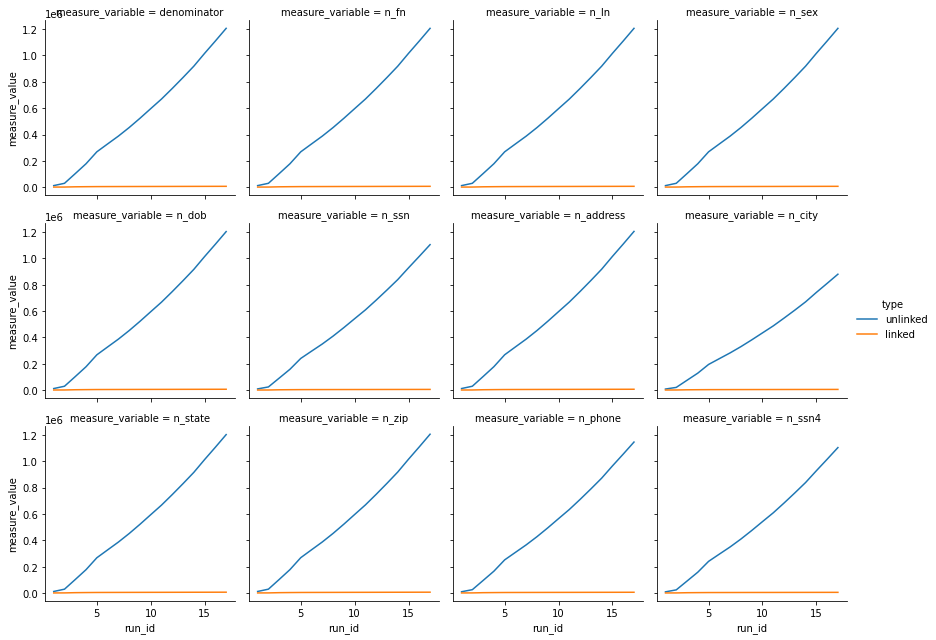

In [115]:
g = sns.FacetGrid(lvcountsdf,col='measure_variable',hue='type',col_wrap=4)
g.map(sns.lineplot,'run_id','measure_value').add_legend()

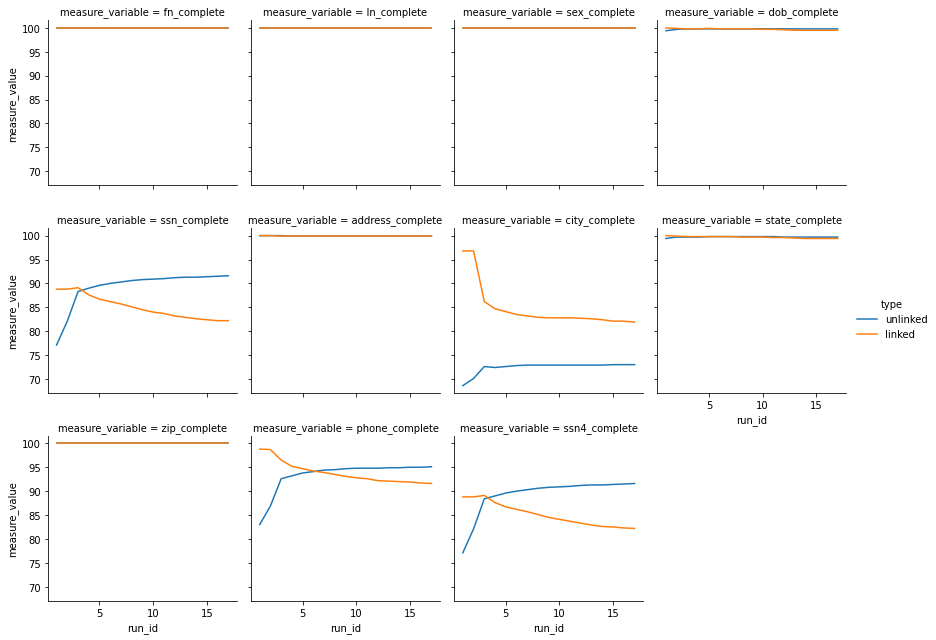

In [116]:
g = sns.FacetGrid(lvpercentsdf,col='measure_variable',hue='type',col_wrap=4)
g.map(sns.lineplot,'run_id','measure_value').add_legend()

In [121]:
obsperioddf['measure_variable'].value_counts()

max_enddate       34
min_obs_months    34
max_obs_months    34
avg_obs_months    34
min_startdate     34
Name: measure_variable, dtype: int64

In [131]:
df['measure_value'] = df['measure_value'].astype('float')

<ipython-input-131-bb5654a866d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['measure_value'] = df['measure_value'].astype('float')


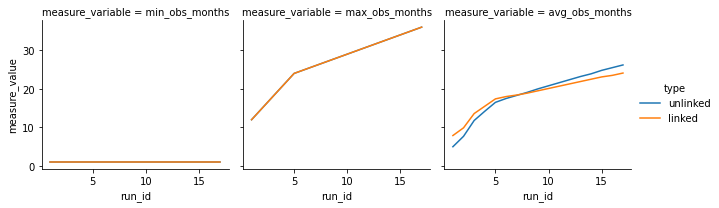

In [133]:
g = sns.FacetGrid(df,col='measure_variable',hue='type')
g.map(sns.lineplot,'run_id','measure_value').add_legend()

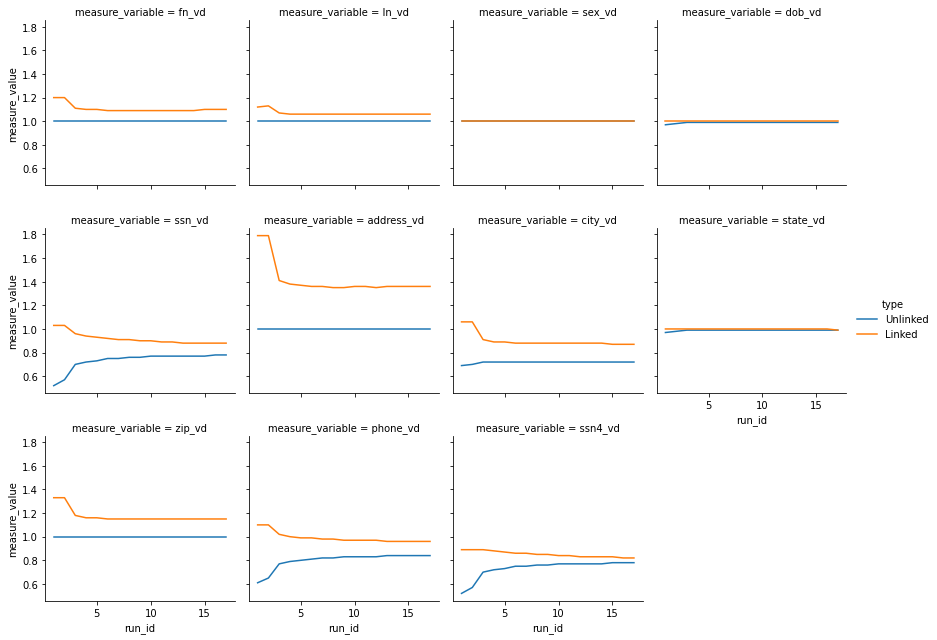

In [134]:
g = sns.FacetGrid(obsperiod_histogramdf,col='measure_variable',hue='type',col_wrap=4)
g.map(sns.lineplot,'run_id','measure_value').add_legend()

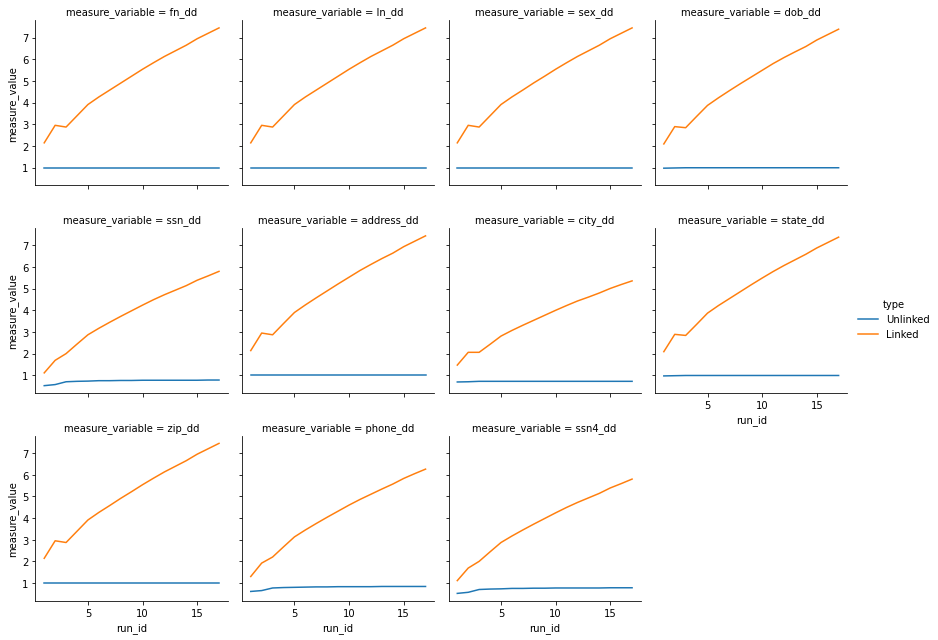

In [136]:
g = sns.FacetGrid(data_densitydf,col='measure_variable',hue='type',col_wrap=4)
g.map(sns.lineplot,'run_id','measure_value').add_legend()

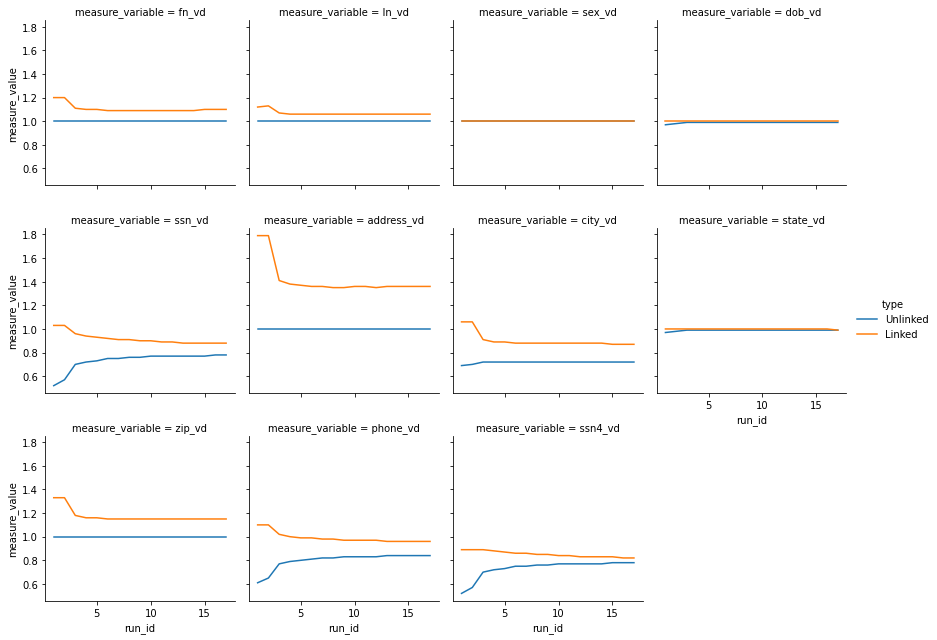

In [137]:
g = sns.FacetGrid(value_densitydf,col='measure_variable',hue='type',col_wrap=4)
g.map(sns.lineplot,'run_id','measure_value').add_legend()